In [1]:
# Import necessary libraries
import pandas as pd
import os
import numpy as np
import json
import re
from collections import Counter
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from collections import defaultdict
import plotly.express as px
from scipy.stats import sem, mannwhitneyu
import sys
sys.path.insert(0, 'src')
# from misc_scripts import scripts
import importlib
import utils.utils_semantic as us
importlib.reload(us)

<module 'utils.utils_semantic' from 'c:\\Users\\alext\\Desktop\\EPFL\\Semester 3\\ADA\\ada-2024-project-badax\\src\\utils\\utils_semantic.py'>

## Loading dataset with cleaned summaries

In [2]:
# Define the path to the preprocessed data
preprocessed_file_path = 'data/preprocessed_movies.parquet'  

df = pd.read_parquet(preprocessed_file_path)
df.head()

,Wikipedia_movie_ID,Movie_name,Actor gender,Movie_countxries,Movie_release_date,Character name,Movie_Summary,Female Percentage,Clean_Summary
0,975900,Ghosts of Mars,"[F, F, M, M, F, F, F, M, M, M, M, M, M, M, M, ...","{""/m/09c7w0"": ""United States of America""}",2001-08-24,"[Akooshay, Lieutenant Melanie Ballard, Desolat...","Set in the second half of the 22nd century, th...",35.294118,set second half nd century depict mar planet t...
1,9363483,White Of The Eye,"[M, F]","{""/m/07ssc"": ""United Kingdom""}",1987,"[None, None]",A series of murders of rich young women throug...,50.000000,series murder rich young woman arizona bear di...
2,261236,A Woman in Flames,"[F, M, M]","{""/m/0345h"": ""Germany""}",1983,"[None, None, None]","Eva, an upper class housewife, becomes frustra...",33.333333,eva upper class housewife frustrated leave arr...
3,18998739,The Sorcerer's Apprentice,"[None, F, M, M, M, None, None, M]","{""/m/0hzlz"": ""South Africa""}",2002,"[None, Morgana, None, None, None, None, None, ...","Every hundred years, the evil Morgana returns...",20.000000,year evil morgana return claim fingall talisma...
4,6631279,Little city,"[M, F, F, M, F, F]","{""/m/09c7w0"": ""United States of America""}",1997-04-04,"[None, Rebecca, Nina, None, None, None]","Adam, a San Francisco-based artist who works a...",66.666667,adam san franciscobase artist work cab driver ...


## Cleaning summaries


This code cleans and filters movie summaries. It removes rows with invalid summaries, tokenizes the text, and identifies words that are too common or too rare. It then filters out these words, leaving only the useful tokens and key fields in the dataset.

In [3]:
df=us.preprocess_movie_data(df)
df.head()


,Wikipedia_movie_ID,Movie_name,Movie_countries,Movie_release_date,Female Percentage,tokens_filtered
0,975900,Ghosts of Mars,[United States of America],2001-08-24,35.294118,"[set, second, half, nd, century, depict, mar, ..."
1,9363483,White Of The Eye,[United Kingdom],NaT,50.000000,"[series, murder, rich, young, woman, arizona, ..."
2,261236,A Woman in Flames,[Germany],NaT,33.333333,"[eva, upper, class, housewife, frustrated, lea..."
3,18998739,The Sorcerer's Apprentice,[South Africa],NaT,20.000000,"[year, evil, morgana, return, claim, talisman,..."
4,6631279,Little city,[United States of America],1997-04-04,66.666667,"[adam, san, artist, work, cab, driver, hard, t..."


The dataset now contains only the necessary information for the following analysis, all cleaned and ready to use. In particular it has the production country of each movie, the release date, female percentage and a list of word tokens filtered to only have lemmatised relevant words.

## Semantic analysis

This code establishes various thematic or emotional categories, associates them with specific seed words, and uses a pre-trained language model to generate related word embeddings. By identifying which tokens in a dataset are semantically closest to each category, it creates comprehensive sentiment lexicons. These lexicons are then used to compute sentiment-like scores for each document.

**Step-by-Step Explanation**:  
1. **Define Categories and Seed Words**:  
   Sets of seed words are assigned to categories (e.g., love, aggression, violence) to represent thematic or emotional dimensions.

2. **Load Embedding Model**:  
   A sentence transformer model is loaded to embed words into a numerical vector space.

3. **Compute Category Centroids**:  
   For each category, embeddings of the seed words are averaged to form a centroid vector, representing the category’s semantic center.

4. **Find Top Similar Words**:  
   By comparing each category’s centroid to all token embeddings in the movie dataset, the code finds the most semantically similar words and uses them to expand each category’s lexicon.

5. **Generate Sentiment Lexicons**:  
   These expanded sets of words form detailed lexicons that represent each category’s semantic field.

6. **Compute Sentiment Scores**:  
   Each document’s tokens are matched against these lexicons, and the frequency of matching words is used to compute category-specific sentiment-like scores.


In [4]:
# Define Categories and Seed Words 

love_words = {
    "love", "romance", "affection", "adore", "loving", "cherish", "passion",
    "attraction", "intimacy", "devotion"
}

aggression_words = {
    "aggression", "anger", "hostile", "rage", "fury", "wrath", "irritation", 
    "belligerence", "antagonism", "resentment"
}

violence_words = {
    "murder", "kill", "violence", "attack", "weapon", "war", "brutal", "bloodshed", 
    "assault", "slaughter"
}

family_words = {
    "family", "mother", "father", "brother", "sister", "child", "children", 
    "daughter", "son", "parent"
}

happiness_words = {
    "happy", "joy", "pleasure", "delight", "glad", "cheerful", "elated", 
    "content", "bright", "optimistic"
}

sadness_words = {
    "sad", "sorrow", "grief", "melancholy", "depressed", "downcast", "tearful", 
    "unhappy", "miserable", "lament"
}

fear_words = {
    "fear", "scared", "frightened", "afraid", "terrified", "anxious", "uneasy", 
    "wary", "alarmed", "panic"
}

empowerment_words = {
    "empower", "empowered", "empowering", "independent", "strong", "leadership",
    "authority", "self-reliant", "resilient", "determined"
}

relationships_words = {
    "friendship", "friend", "friends", "romance", "romantic", "relationship",
    "partner", "partners", "mentorship", "mentor"
}

career_words = {
    "career", "profession", "job", "work", "office", "business", "entrepreneur",
    "startup", "manager", "lead"
}

social_issues_words = {
    "feminism", "equality", "diversity", "activism", "social justice",
    "discrimination", "inclusion", "rights", "empowerment", "advocacy"
}

emotional_complexity_words = {
    "anxiety", "hope", "despair", "joy", "grief", "anticipation", "surprise",
    "trust", "disgust", "anticipate"
}

heroism_words = {
    "hero", "heroic", "sacrifice", "courage", "bravery", "valor", "chivalry",
    "noble", "selfless", "altruism"
}

conflict_resolution_words = {
    "conflict", "resolve", "resolution", "battle", "fight", "struggle",
    "tension", "dispute", "argument", "clash"
}

adventure_words = {
    "adventure", "exploration", "journey", "quest", "voyage", "expedition",
    "trek", "odyssey", "discover", "explore"
}

mystery_words = {
    "mystery", "suspense", "intrigue", "secret", "unknown", "puzzle",
    "enigma", "clue", "detective", "investigation"
}

technology_words = {
    "technology", "innovate", "innovation", "science", "future", "robot",
    "AI", "artificial intelligence", "cyber", "digital"
}

# Combine all sentiment categories into a dictionary
categories = {
    "love_score": love_words,
    "aggression_score": aggression_words,
    "violence_score": violence_words,
    "family_score": family_words,
    "happiness_score": happiness_words,
    "sadness_score": sadness_words,
    "fear_score": fear_words,
    "empowerment_score": empowerment_words,
    "relationships_score": relationships_words,
    "career_score": career_words,
    "social_issues_score": social_issues_words,
    "emotional_complexity_score": emotional_complexity_words,
    "heroism_score": heroism_words,
    "conflict_resolution_score": conflict_resolution_words,
    "adventure_score": adventure_words,
    "mystery_score": mystery_words,
    "technology_score": technology_words
}


After the categories have been defined all tokens need to be emebedded to be able to calculate cosine similarity. So a simple emebedding model is loaded.

In [5]:
# Load the Embedding Model
model = SentenceTransformer("all-MiniLM-L6-v2")


For every category the centroid is calculated by calculating the mean of the set of embedded seed words for each category. Defining seed words allow us to have an idea of the semantic center of each category.

In [6]:
# Compute centroid embeddings for each category

category_centroids = {}
for cat, seed_words in categories.items():
    seed_embeddings = model.encode(list(seed_words), batch_size=32) #calculate embeddings of seed words
    centroid = np.mean(seed_embeddings, axis=0)                     #calculate centroid of emebeddings of see words
    category_centroids[cat] = centroid                              #append to list


This code extracts unique tokens from the movie dataset, encodes them into vector embeddings using the model, and stores these embeddings in a dictionary for later use.


In [7]:
# Flatten all tokens and get unique tokens
print("Collecting unique tokens...")
all_tokens = set(token for tokens in df['tokens_filtered'] for token in tokens)
all_tokens = list(all_tokens)
print(f"Total unique tokens: {len(all_tokens)}")

# Encode all unique tokens in batches and create a token-to-embedding map
batch_size = 1024
token_embeddings = {}

for i in range(0, len(all_tokens), batch_size):
    batch_tokens = all_tokens[i:i+batch_size]
    embeddings = model.encode(batch_tokens, batch_size=256)
    for token, embedding in zip(batch_tokens, embeddings):
        token_embeddings[token] = embedding

Total unique tokens: 30362


In [8]:
# Generate Sentiment Lexicons
sentiment_lexicons = {}
top_k = 100  # Number of top similar words to consider for each category

#For every category we get the top n similar words by calculating the cosine similarities bewtween the centroids and the set of unique tokens in the movie dataset
for cat, centroid in category_centroids.items():
    top_words = us.get_top_n_similar_words(centroid, token_embeddings, top_n=top_k)
    sentiment_lexicons[cat] = set([word for word, score in top_words])

#Display top 10 words for each category
for cat, words in sentiment_lexicons.items():
    print(f"\nCategory: {cat.replace('_score', '').capitalize()}")
    print("-" * (10 + len(cat)))
    print(", ".join(list(words)[:10]) + ", ...")  # Display first 10 words for brevity



Category: Love
--------------------
relationship, attraction, loveinterest, marital, amor, kiss, erotically, romantic, sexual, hugging, ...

Category: Aggression
--------------------------
quarrelsome, ferocious, attack, infuriate, wrath, disdain, confrontation, belligerent, enraged, mad, ...

Category: Violence
------------------------
shooting, wounding, devastation, death, attack, abuse, mortally, insurgency, stabbing, crime, ...

Category: Family
----------------------
stepfather, spouse, brothers, mom, fathers, parenting, kid, childrens, dada, kiddie, ...

Category: Happiness
-------------------------
blissfully, enthusiasm, cherished, enjoy, pleased, satisfaction, sleepy, feeling, happiness, love, ...

Category: Sadness
-----------------------
mourn, disdain, depressionera, devastated, dreadful, tearful, consolation, angry, dying, stressful, ...

Category: Fear
--------------------
exposed, anxious, fearless, paranoid, frighten, unsafe, cautious, alarmed, fearfully, reassure, ..

To more easily visualise the category centroids and the top 100 words for each category, we also plot the emebedded vectors in a 3d space, after performing dimensionality reduction

In [9]:
us.visualize_centroids_and_words(category_centroids, sentiment_lexicons, token_embeddings)

# Computing scores

This script calculates sentiment scores for each movie by analyzing the frequency of sentiment-related words in the movie's text. It then splits the movies into two groups: those with ≥66% female representation and those with ≤33% female representation. For each sentiment category, the script computes the average scores and their standard errors for both groups. Finally, it visualizes the differences using an interactive bar chart, highlighting how sentiment varies based on the gender composition of the movies.

In [10]:
import pandas as pd
from collections import defaultdict

df = us.calculate_sentiment_for_dataframe(df, sentiment_lexicons)

In [11]:
df.head()

,Wikipedia_movie_ID,Movie_name,Movie_countries,Movie_release_date,Female Percentage,tokens_filtered,love_score,aggression_score,violence_score,family_score,...,empowerment_score,relationships_score,career_score,social_issues_score,emotional_complexity_score,heroism_score,conflict_resolution_score,adventure_score,mystery_score,technology_score
0,975900,Ghosts of Mars,[United States of America],2001-08-24,35.294118,"[set, second, half, nd, century, depict, mar, ...",0.005556,0.022222,0.083333,0.000000,...,0.016667,0.027778,0.016667,0.022222,0.011111,0.000000,0.038889,0.016667,0.022222,0.005556
1,9363483,White Of The Eye,[United Kingdom],NaT,50.000000,"[series, murder, rich, young, woman, arizona, ...",0.020690,0.006897,0.055172,0.017241,...,0.000000,0.024138,0.013793,0.000000,0.010345,0.006897,0.003448,0.013793,0.031034,0.006897
2,261236,A Woman in Flames,[Germany],NaT,33.333333,"[eva, upper, class, housewife, frustrated, lea...",0.035503,0.011834,0.005917,0.011834,...,0.017751,0.053254,0.023669,0.005917,0.011834,0.000000,0.005917,0.017751,0.000000,0.000000
3,18998739,The Sorcerer's Apprentice,[South Africa],NaT,20.000000,"[year, evil, morgana, return, claim, talisman,...",0.000000,0.000000,0.045455,0.030303,...,0.015152,0.015152,0.000000,0.000000,0.000000,0.000000,0.045455,0.030303,0.015152,0.000000
4,6631279,Little city,[United States of America],1997-04-04,66.666667,"[adam, san, artist, work, cab, driver, hard, t...",0.040000,0.000000,0.000000,0.010000,...,0.000000,0.080000,0.020000,0.000000,0.010000,0.000000,0.000000,0.000000,0.000000,0.000000


In [12]:
# --- Split the Data into Female and Male Majority Movies ---
# Define the subsets based on Female Percentage
female_movies = df[df["Female Percentage"] >= 66].copy()
male_movies = df[df["Female Percentage"] <= 33].copy()

print(f"\nNumber of female-majority movies (≥66% female): {female_movies.shape[0]}")
print(f"Number of male-majority movies (≤33% female): {male_movies.shape[0]}")

# Identify sentiment columns (those ending with '_score')
sentiment_cols = [col for col in df.columns if col.endswith("_score")]

# Compute mean and SEM for each sentiment in female_movies
female_means = female_movies[sentiment_cols].mean()
female_se = female_movies[sentiment_cols].apply(sem)

# Compute mean and SEM for each sentiment in male_movies
male_means = male_movies[sentiment_cols].mean()
male_se = male_movies[sentiment_cols].apply(sem)

# Combine the results into a single DataFrame for easier plotting
sentiment_stats = pd.DataFrame({
    'Female Movies Mean': female_means,
    'Female Movies SEM': female_se,
    'Male Movies Mean': male_means,
    'Male Movies SEM': male_se
})


sentiment_stats.head()



Number of female-majority movies (≥66% female): 3429
Number of male-majority movies (≤33% female): 17466


,Female Movies Mean,Female Movies SEM,Male Movies Mean,Male Movies SEM
love_score,0.020562,0.000508,0.010501,0.000146
aggression_score,0.006199,0.000215,0.008018,0.000105
violence_score,0.019449,0.000487,0.027830,0.000226
family_score,0.056684,0.000908,0.034791,0.000318
happiness_score,0.011680,0.000342,0.006913,0.000101


In [13]:
us.plot_sentiment_comparison(sentiment_stats, sentiment_cols)

# Assessing Statistical Significance of Sentiment Differences

While the previous bar chart highlights some differences in sentiment scores between female-majority and male-majority movies, it's important to determine if these differences are statistically significant.

- **Statistical Testing**:
  - **Mann-Whitney U Test**: Conducted for each sentiment category to compare female-majority (≥66% female) and male-majority (≤33% female) movies.
  
- **Findings**:
  - Identified sentiment categories with p-values below 0.05, indicating significant differences.
  - Specified whether the higher sentiment score is associated with female-majority or male-majority movies.

This analysis confirms which observed differences in sentiment are meaningful and not due to random variation.

In [14]:
df_results = us.perform_stat_tests(female_movies, male_movies, sentiment_cols, female_means, male_means)
df_results


,Sentiment,U-Statistic,P-Value,Significant,Direction
0,love_score,36193799.5,3.206917e-94,Yes,female
1,aggression_score,26401603.5,2.063310e-32,Yes,male
2,violence_score,23519457.5,2.177601e-90,Yes,male
3,family_score,38023206.0,6.291309e-140,Yes,female
4,happiness_score,33297467.5,4.017729e-30,Yes,female
5,sadness_score,31691236.5,1.885024e-10,Yes,female
6,fear_score,29019803.0,9.409102e-04,Yes,female
7,empowerment_score,26941288.0,3.021976e-25,Yes,male
8,relationships_score,37245083.0,7.160937e-115,Yes,female
9,career_score,27404876.5,1.836952e-15,Yes,male


These results are then summarised in a table, generated by the follwoing code and to be used in the website

In [15]:
#optionally create a table for a markdown file to be displayied in the website
us.generate_sentiment_comparison_markdown(female_means, male_means, female_movies, male_movies, sentiment_cols)


Markdown table saved to sentiment_comparison.md


To identify the top 5 sentiments that exhibit the most significant differences between the two datasets, we calculate the mean differences for each sentiment column. These top sentiments are then utilized later in the code to focus exclusively on displaying sentiments with substantial disparities.

In [16]:
# Calculate the mean differences for each sentiment column
mean_differences = {
    sentiment: abs(
        sentiment_stats['Female Movies Mean'][i] -
        sentiment_stats['Male Movies Mean'][i]
    )
    for i, sentiment in enumerate(sentiment_cols)
}

# Sort sentiments by the mean differences and select the top 5
top_5_sentiments = sorted(mean_differences, key=mean_differences.get, reverse=True)[:5]

# Output the selected sentiments for further use
print("Top 5 Sentiments with Largest Differences:", top_5_sentiments)


Top 5 Sentiments with Largest Differences: ['family_score', 'relationships_score', 'love_score', 'violence_score', 'happiness_score']


C:\Users\alext\AppData\Local\Temp\ipykernel_2936\2803328424.py:4: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

C:\Users\alext\AppData\Local\Temp\ipykernel_2936\2803328424.py:5: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



# Visualizing Sentiment Trends Over Time

Building on the previous analysis where we observed differences in sentiment scores between female-majority and male-majority movies, it's essential to explore whether these differences hold true over time.

- **Trend Analysis**:
  - **Time Series Plots**: The script visualizes the trends of selected sentiment categories across different years for both high female percentage (≥66%) and low female percentage (≤33%) movies.
  - **Subgroup Comparison**: By plotting regression lines for each subset, we can assess how sentiment scores evolve and whether the initial differences become more pronounced, diminish, or remain stable over the years.

This is now down for the top 5 sentiments and later on done for all sentiments, saving the plots in the images folder.

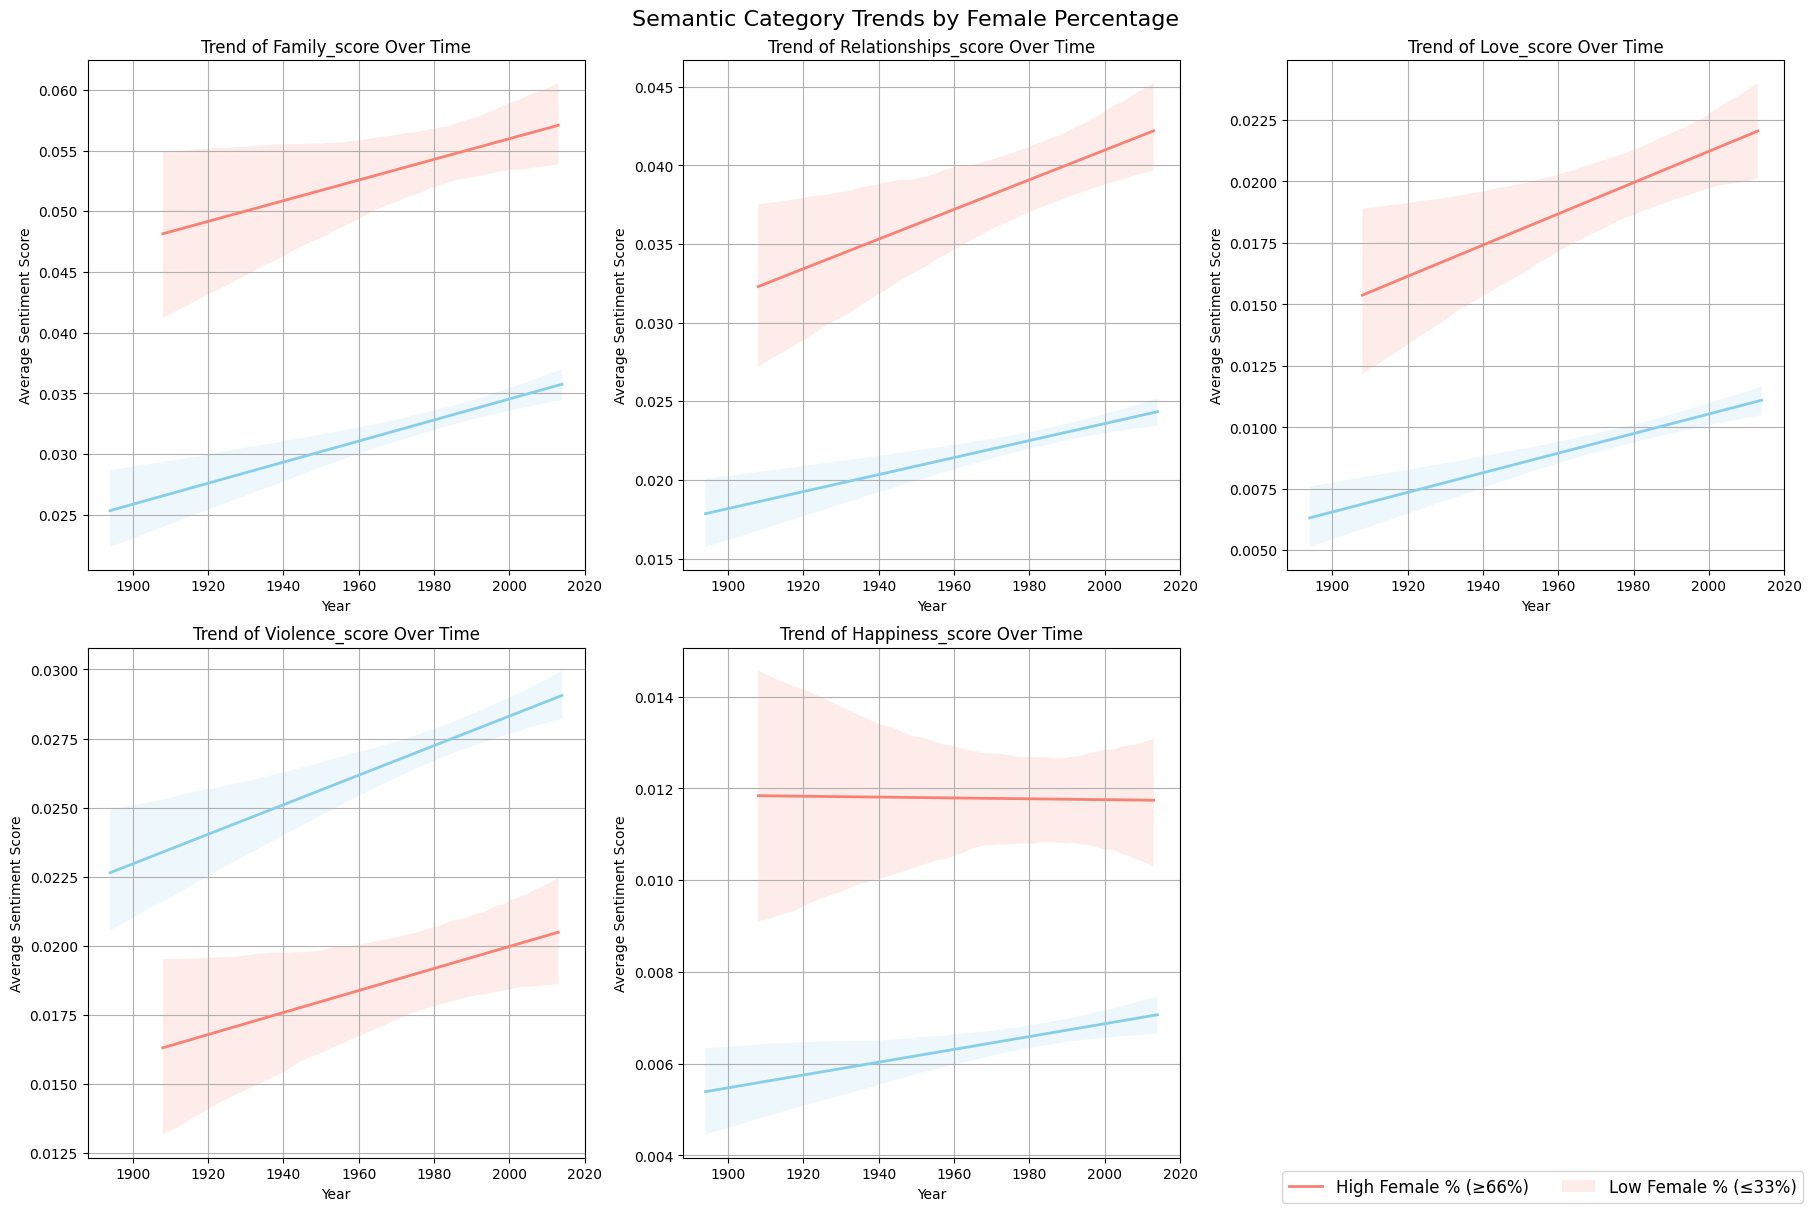

In [17]:
us.plot_sentiment_trends_over_time(df, top_5_sentiments)

To generalize the previous trend analysis to all sentiment categories, the following function automates the generation and organization of plots for each category.

Automate Plot Generation:

Create Directory: Ensures an images folder exists to store all sentiment trend plots.
Generate Plots: Iterates through each sentiment category, creates a regression plot showing trends over time for both high and low female percentage movies, and saves each plot as a PNG file in the images folder.
Create Interactive HTML Viewer:

List Images: Retrieves all PNG files from the images directory.
Build HTML Interface: Constructs an HTML page with a dropdown menu allowing users to select and view any of the saved sentiment trend plots interactively.

In [18]:
us.create_image_selector_html('.')

HTML file created: .\image_selector.html


# Exploring sentiment score as a function of female representation
We have seen significant differences between male-majority and female-majority movie datasets. Now, we examine whether these differences persist as the female percentage increases. The following plot visualizes how sentiment scores correlate with the female percentage in movies.

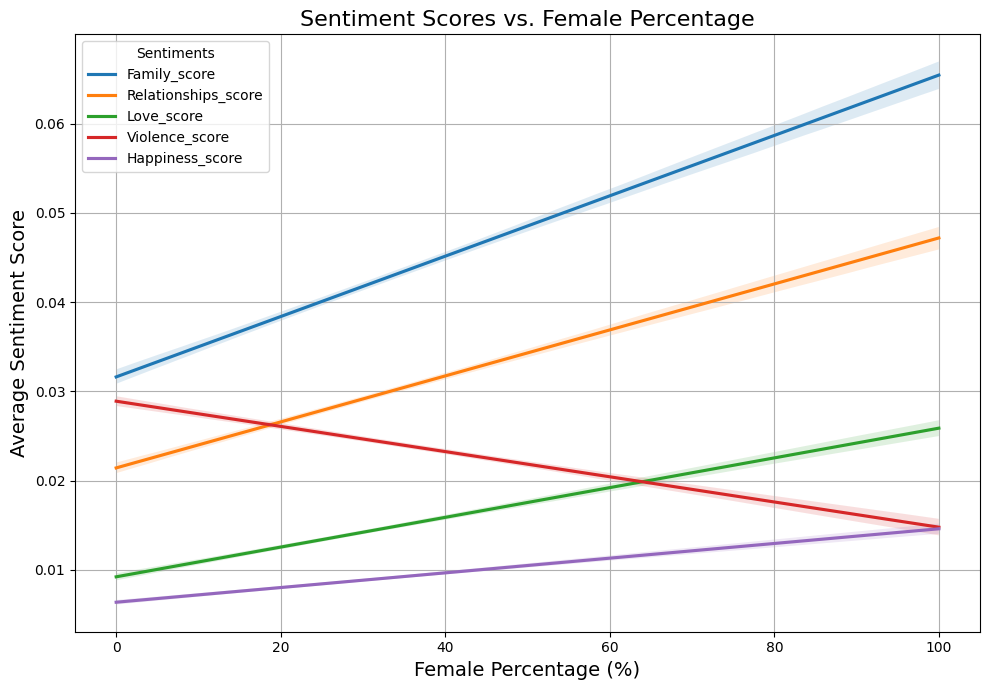

In [19]:
# Initialize the matplotlib figure
plt.figure(figsize=(10, 7))
# Define a color palette for the top 5 sentiments
colors = sns.color_palette("tab10", n_colors=5)

# Loop through each sentiment and plot
for sentiment, color in zip(top_5_sentiments, colors):
    sns.regplot(
        x='Female Percentage',
        y=sentiment,
        data=df,
        scatter=False,
        label=sentiment.replace('_proximity', '').capitalize(),
        color=color,
        # line_kws={'linewidth': 2}
    )

# Customize the plot
plt.xlabel('Female Percentage (%)', fontsize=14)
plt.ylabel('Average Sentiment Score', fontsize=14)
plt.title('Sentiment Scores vs. Female Percentage', fontsize=16)
plt.legend(title='Sentiments')
plt.grid(True)
plt.tight_layout()

# Display the plot
plt.show()


The graph illustrates that as the percentage of females in movies increases, sentiments related to family, relationships, and love generally rise, whereas violence tends to decrease. Happiness sentiment remains relatively stable across varying levels of female representation.

# Geographical Sentiment Analysis in Movies

We have identified significant sentiment differences between male-majority and female-majority movies. To explore if these differences are consistent across various countries, the following code visualizes sentiment scores geographically.

- **Data Preparation**:
  - **Expand Countries**: Splits the `Movie_countries` column to have one country per row.
  - **Categorize Movies**: Separates movies into "High Female % (≥66%)" and "Low Female % (≤33%)".

- **Calculate Averages**:
  - **Group by Country**: Computes average sentiment scores for both female-majority and male-majority movies in each country.
  - **Merge Data**: Combines the scores for comparison.

- **Create Interactive Maps**:
  - **Choropleth Maps**: Uses Plotly to display countries where female-majority movies have higher sentiment scores (salmon) versus male-majority (skyblue).
  - **Dropdown Selection**: Allows users to choose different sentiment categories to visualize.

- **Output**:
  - **Interactive Visualization**: Enables exploration of regional sentiment trends related to gender representation.
  - **HTML Export**: Saves the interactive map as `geographic_sentiment_score.html` for easy sharing.

This analysis highlights regional patterns in how gender representation influences sentiment in movies worldwide.

In [20]:
df = df.explode('Movie_countries').reset_index(drop=True)

# Separate female-majority and male-majority movies
female_movies = df[df['Subset'] == 'High Female % (≥66%)']
male_movies = df[df['Subset'] == 'Low Female % (≤33%)']

# Define semantic score columns (assuming they end with '_proximity')
sentiment_cols = [col for col in df.columns if col.endswith('_score')]

# Group by country and calculate mean scores for female and male subsets
female_country_scores = female_movies.groupby('Movie_countries')[sentiment_cols].mean().reset_index()
male_country_scores = male_movies.groupby('Movie_countries')[sentiment_cols].mean().reset_index()

# Combine the scores into a single DataFrame for comparison
country_comparison = female_country_scores.merge(
    male_country_scores,
    on='Movie_countries',
    how='outer',
    suffixes=('_female', '_male')
)

# Plotting the comparison for a specific sentiment (e.g., "love_proximity")
selected_sentiment = 'family_score'  # Adjust based on your actual column names

# Prepare data for plotting
data_to_plot_female = country_comparison[['Movie_countries', f'{selected_sentiment}_female']].dropna()
data_to_plot_female.rename(columns={
    'Movie_countries': 'country',
    f'{selected_sentiment}_female': 'Female_Majority_Score'
}, inplace=True)

data_to_plot_male = country_comparison[['Movie_countries', f'{selected_sentiment}_male']].dropna()
data_to_plot_male.rename(columns={
    'Movie_countries': 'country',
    f'{selected_sentiment}_male': 'Male_Majority_Score'
}, inplace=True)

data_to_plot = data_to_plot_male.merge(data_to_plot_female, on='country', how='inner')
data_to_plot['Female_majority'] =data_to_plot['Female_Majority_Score'] > data_to_plot['Male_Majority_Score']
data_to_plot.head()


,country,Male_Majority_Score,Female_Majority_Score,Female_majority
0,Algeria,0.060916,0.052632,False
1,Argentina,0.040813,0.069868,True
2,Armenia,0.047190,0.075000,True
3,Australia,0.033791,0.062735,True
4,Austria,0.031318,0.031803,True


In [21]:
import plotly.graph_objects as go
us.create_sentiment_choropleth(country_comparison, sentiment_cols)
